In [1]:
import os.path as osp
import time
import pickle
import sys
import os
import numpy as np
code_path = os.path.abspath('../code')
sys.path.append(code_path)
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from tqdm import tqdm

from model import DeepVCF_Model
from data_utils import DeepVCF_Knowledge, DeepVCF_Data
from utils import set_seeds

## loading trained model
User can trained their own model using our code (see train_deepvcf.py) \

In [2]:
# load model after training(train_deepvcf.py)
model_dir = '/home/shengkun/lab_github/DeepVCF/trained_model/ECO/'
model_name = 'DeepVCF_k10_20260109'
device = 'cuda:2'

In [3]:
# load trained DeepVCF
entity2idx = np.load(model_dir+'index_dict/entity2idx.npy', allow_pickle=True).item()
relation2idx = np.load(model_dir+'index_dict/relation2idx.npy', allow_pickle=True).item()
model = DeepVCF_Model.load_model(model_dir + model_name + '.pt', device=device)

[OK] Model loaded ← /home/shengkun/lab_github/DeepVCF/trained_model/ECO/DeepVCF_k10_20260109.pt


## Reproducing results
Change test_path to report results on metabolic target prediction or non-metabolic target prediction \
results are based on our reproduced DeepVCF model. \
→If reproduce DeepVCF_PreFT, plz enable model.train_tpn(pre_data_list) in train_deepvcf.py


In [4]:
train_path = '/home/shengkun/lab_github/DeepVCF/data/me_data/train_data/train.txt'
test_path = '/home/shengkun/lab_github/DeepVCF/data/me_data/metabolic_gene/combined_test.txt'
d_processor = DeepVCF_Data(train_path, test_path,
                        model_dir,
                        ensemble=True)
data_list = d_processor.process()
all_out, all_label, ensemble_metrics, indiv_outputs, indiv_metrics = model.test_tpn(data_list,test=True)   
print(ensemble_metrics)
print(indiv_metrics)

Loading index dictionaries for task data...
Train:7183; Valid:1796; Test:2187
Train:7183; Valid:1796; Test:2187
Train:7183; Valid:1796; Test:2187
Train:7183; Valid:1796; Test:2187
Train:7184; Valid:1795; Test:2187
{'auroc': np.float64(0.8744265645563336), 'auprc': np.float64(0.6186211899601662), 'accuracy': 0.8920896204846822, 'precision': 0.7708333333333334, 'recall': 0.3535031847133758, 'f1_score': 0.4847161572052402, 'mcc': np.float64(0.47490649134288293)}
[{'auroc': np.float64(0.857555915269281), 'auprc': np.float64(0.5721433574586603), 'accuracy': 0.8802011888431641, 'precision': 0.6494252873563219, 'recall': 0.35987261146496813, 'f1_score': 0.46311475409836067, 'mcc': np.float64(0.4241204651190361)}, {'auroc': np.float64(0.8734437752711172), 'auprc': np.float64(0.5826953513705649), 'accuracy': 0.8829446730681298, 'precision': 0.6542553191489362, 'recall': 0.39171974522292996, 'f1_score': 0.4900398406374502, 'mcc': np.float64(0.44661792084996266)}, {'auroc': np.float64(0.848173508

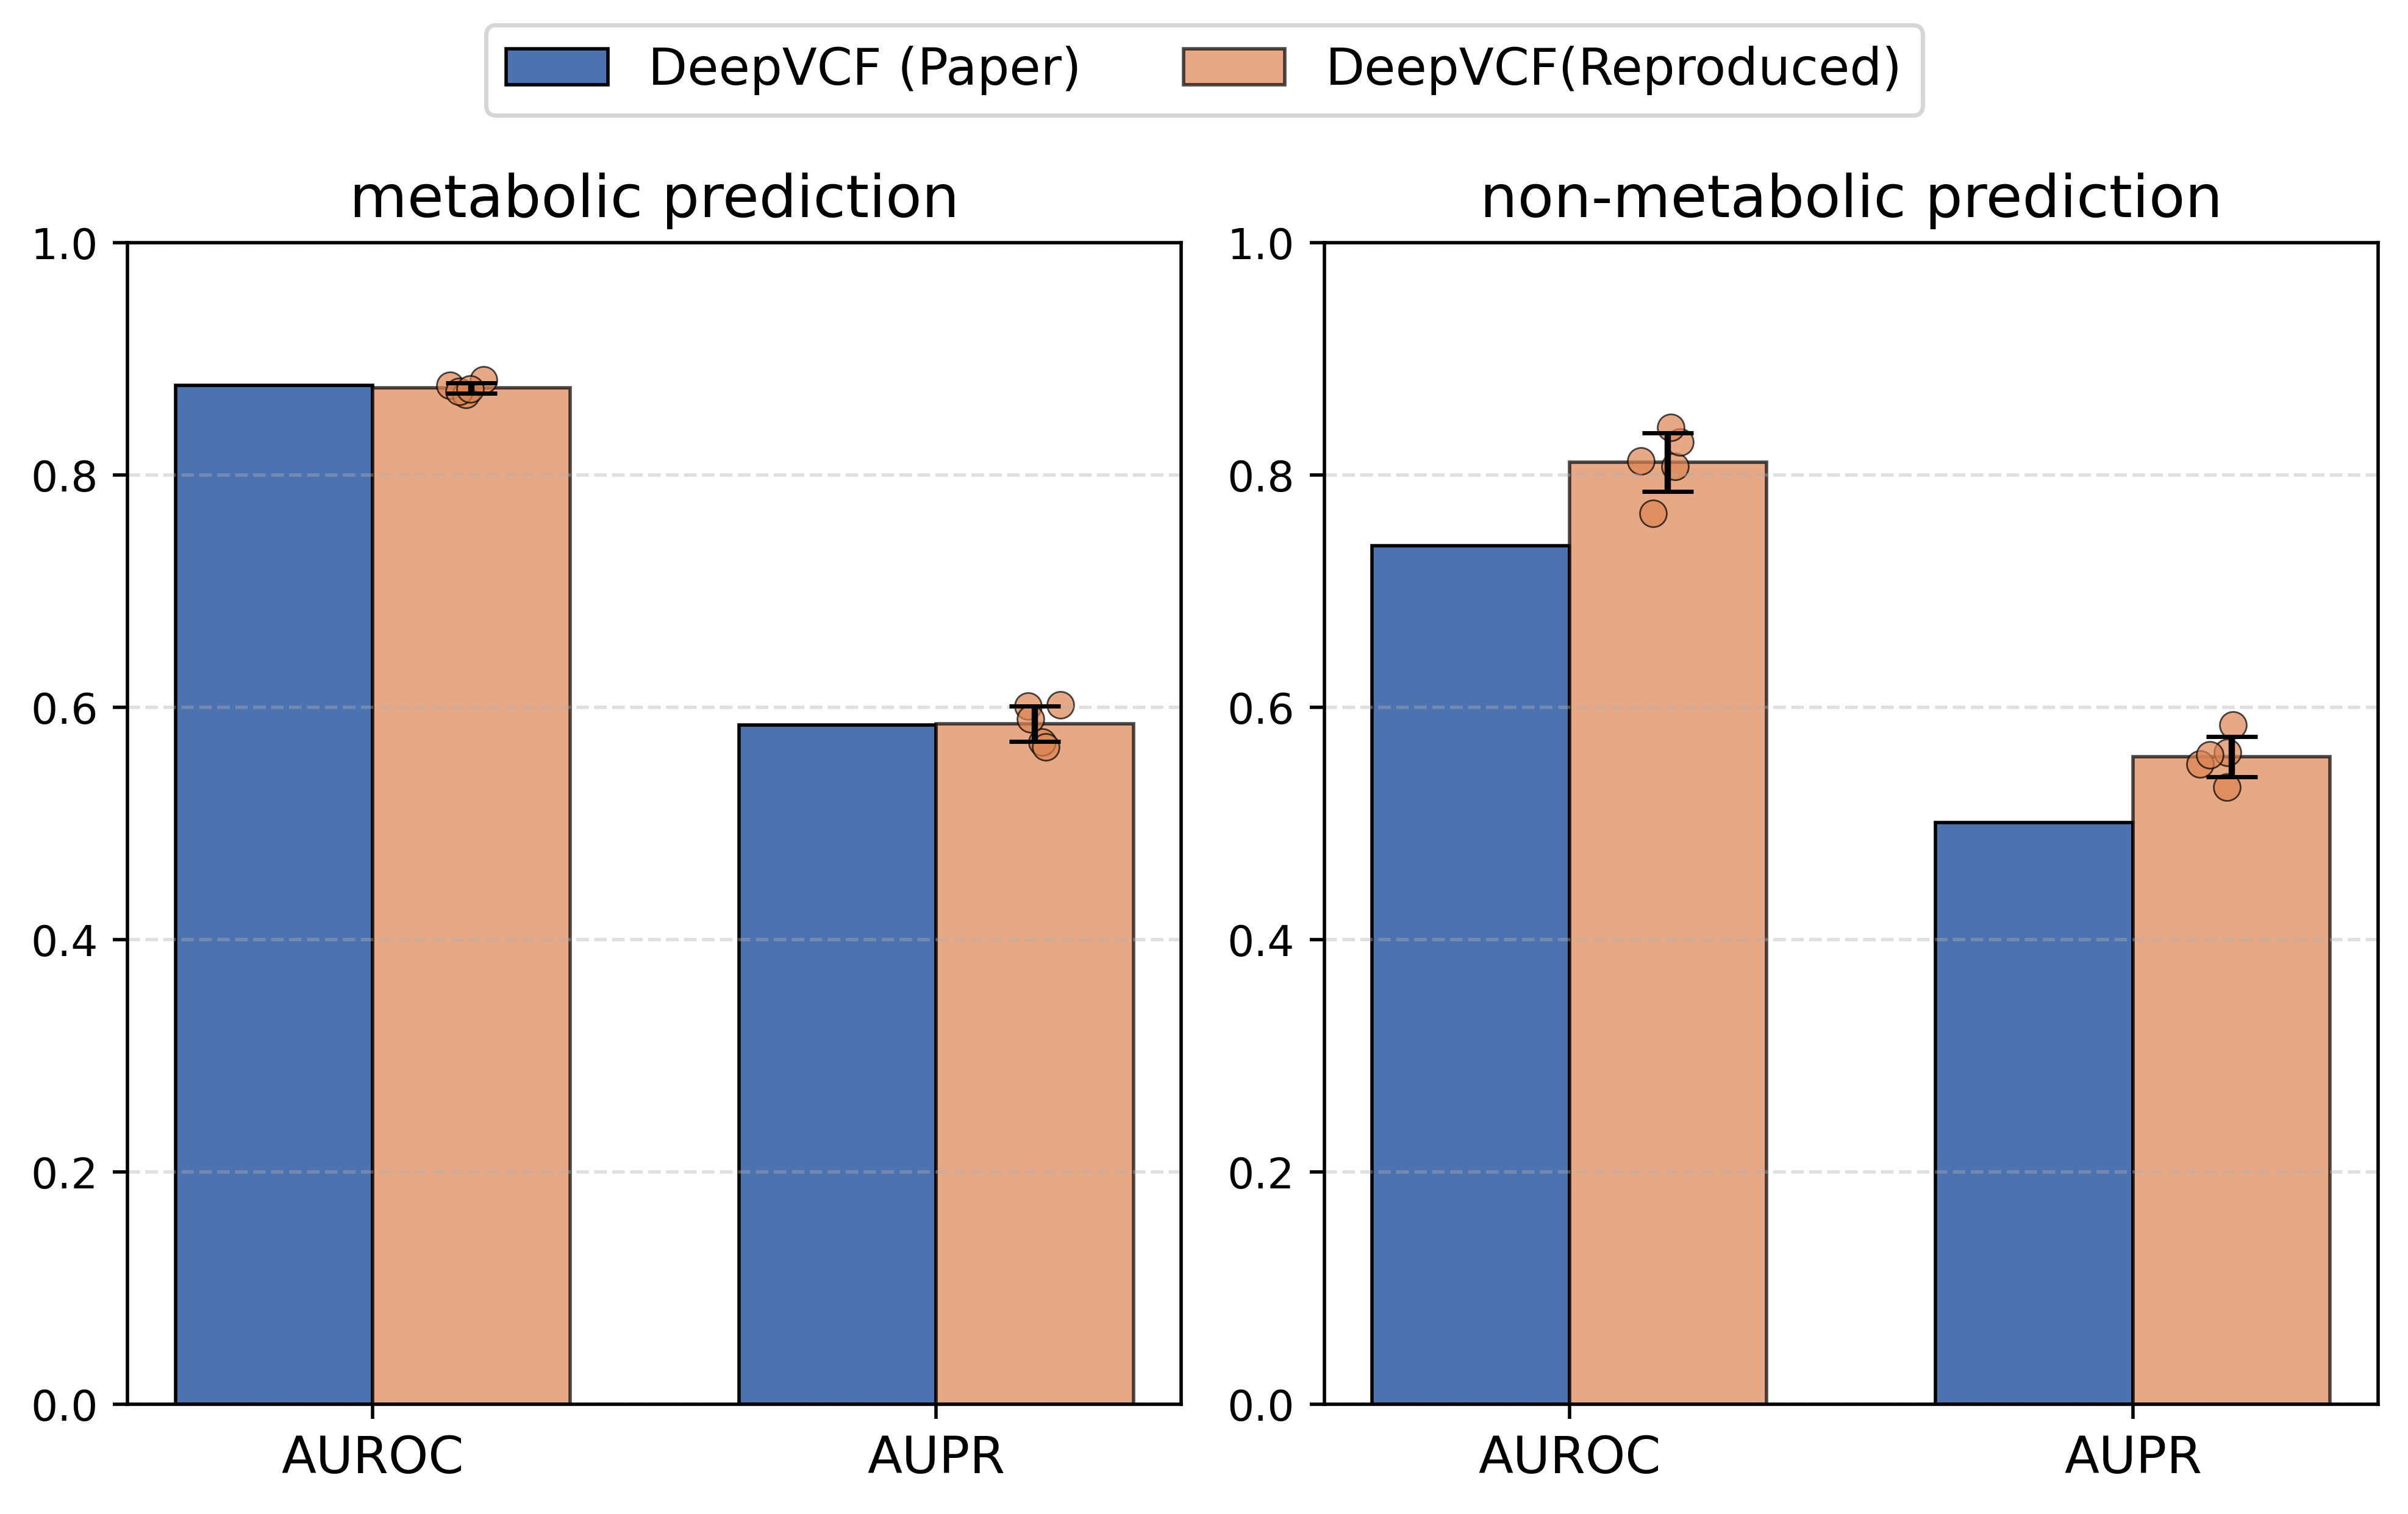

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# summary
# -----------------------------
tasks = ["metabolic", "non-metabolic"]

paper_AUROC = {"metabolic": 0.877, "non-metabolic": 0.739}
paper_AUPR  = {"metabolic": 0.585, "non-metabolic": 0.501}

repr_AUROC = {
    "metabolic": [0.877, 0.869, 0.872, 0.882, 0.874],
    "non-metabolic": [0.767, 0.807, 0.812, 0.828, 0.841]
}
repr_AUPR = {
    "metabolic": [0.601, 0.570, 0.566, 0.602, 0.590],
    "non-metabolic": [0.531, 0.551, 0.561, 0.585, 0.559]
}

# -----------------------------
# 配色 & 参数
# -----------------------------
paper_color = "#4C72B0"      # Blue
repr_color = "#DD8452"       # Orange
repr_alpha = 0.7

bar_width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(8, 5), dpi=500,sharey=False)

for i, task in enumerate(tasks):
    ax = axes[i]
    
    # positions
    x = np.array([0, 1])   # AUROC, AUPR
    x_paper = x - bar_width/2
    x_repr  = x + bar_width/2

    # means
    auroc_mean = np.mean(repr_AUROC[task])
    auroc_std  = np.std(repr_AUROC[task])
    aupr_mean  = np.mean(repr_AUPR[task])
    aupr_std   = np.std(repr_AUPR[task])

    # -----------------------------
    # 画 paper 和 reproduced 柱状图
    # -----------------------------
    # paper bars
    ax.bar(x_paper, 
           [paper_AUROC[task], paper_AUPR[task]],
           width=bar_width,
           color=paper_color,
           label="DeepVCF (Paper)" if i==0 else "",
           edgecolor="black",
           linewidth=0.8)

    # reproduced bars (mean + std)
    ax.bar(x_repr,
           [auroc_mean, aupr_mean],
           width=bar_width,
           yerr=[auroc_std, aupr_std],
           capsize=6,
           color=repr_color,
           alpha=repr_alpha,
           label="DeepVCF(Reproduced)" if i==0 else "",
           edgecolor="black",
           linewidth=0.8)

    # -----------------------------
    # 散点：每次复现
    # -----------------------------
    jitter = 0.03
    ax.scatter(np.random.normal(x_repr[0], jitter, len(repr_AUROC[task])),
               repr_AUROC[task],
               color=repr_color, alpha=0.7, s=40, edgecolor="black", linewidth=0.4)

    ax.scatter(np.random.normal(x_repr[1], jitter, len(repr_AUPR[task])),
               repr_AUPR[task],
               color=repr_color, alpha=0.7, s=40, edgecolor="black", linewidth=0.4)

    # axis formatting
    ax.set_xticks(x)
    ax.set_xticklabels(["AUROC", "AUPR"], fontsize=12)
    ax.set_title(f"{task} prediction", fontsize=14)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    ax.set_ylim(0, 1)

# overall legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", fontsize=12, ncol=2)

plt.tight_layout(rect=[0,0,1,0.92])
plt.show()


## Using DeepVCF for real-world genome-scale target prediction

In [ ]:
# define query metabolite, gene prefix→strain, 
query_met = ['Metabolite:amet_c']
query_gene_prefix = 'ECO_Protein'
gene_type = 'whole genome' # 'whole genome' or 'metabolic gene' or 'non-metabolic gene'
output_dic = 'amet_c'

In [ ]:
model.genome_scale_prediction(query_met, query_gene_prefix, gene_type, entity2idx, relation2idx, output_dic)

## leveraging data transfer strategy for target prediction in data-scarce species
NOTE: The deep representation network is currently trained on a cross-species knowledge graph, which may contain redundant cross-species information. Therefore, We recommend training DeepVCF from scratch for data-rich species. This problem will be addressed in the next version update.

In [2]:
# load cross-species model after training(train_deepvcf.py)
model_dir = '/home/shengkun/lab_github/DeepVCF/trained_model/ALL/'
model_name = 'DeepVCF_k10_20260109'
device = 'cuda:2'

entity2idx = np.load(model_dir+'index_dict/entity2idx.npy', allow_pickle=True).item()
relation2idx = np.load(model_dir+'index_dict/relation2idx.npy', allow_pickle=True).item()
model = DeepVCF_Model.load_model(model_dir + model_name + '.pt', device=device)

[OK] Model loaded ← /home/shengkun/lab_github/DeepVCF/trained_model/ALL/DeepVCF_k10_20260109.pt


In [3]:
# zero-shot prediction
train_path = '/home/shengkun/lab_github/DeepVCF/data/me_data/train_data/train.txt'
test_path = '/home/shengkun/lab_github/DeepVCF/data/me_data/cross_species_transfer/sce/metabolic_test.txt'
d_processor = DeepVCF_Data(train_path, test_path,
                        model_dir,
                        ensemble=True)
data_list = d_processor.process()
all_out, all_label, ensemble_metrics, indiv_outputs, indiv_metrics = model.test_tpn(data_list,test=True)   
print(ensemble_metrics)
print(indiv_metrics)

Loading index dictionaries for task data...
Train:7183; Valid:1796; Test:2008
Train:7183; Valid:1796; Test:2008
Train:7183; Valid:1796; Test:2008
Train:7183; Valid:1796; Test:2008
Train:7184; Valid:1795; Test:2008
{'auroc': np.float64(0.8190136887318854), 'auprc': np.float64(0.461629219276455), 'accuracy': 0.8645418326693227, 'precision': 0.78125, 'recall': 0.08620689655172414, 'f1_score': 0.15527950310559005, 'mcc': np.float64(0.2305454667580986)}
[{'auroc': np.float64(0.8179579302316246), 'auprc': np.float64(0.4413997113836659), 'accuracy': 0.8630478087649402, 'precision': 0.6470588235294118, 'recall': 0.11379310344827587, 'f1_score': 0.1935483870967742, 'mcc': np.float64(0.23083243806350096)}, {'auroc': np.float64(0.791076231383726), 'auprc': np.float64(0.40796892558682113), 'accuracy': 0.8630478087649402, 'precision': 0.6, 'recall': 0.15517241379310345, 'f1_score': 0.2465753424657534, 'mcc': np.float64(0.2552879300293775)}, {'auroc': np.float64(0.8051121994299707), 'auprc': np.floa

In [4]:
# genome-scale prediction same as insturction above
query_met = ['Metabolite:pyr_c']
query_gene_prefix = 'CGL_Protein'
gene_type = 'whole genome' # 'whole genome' or 'metabolic gene' or 'non-metabolic gene'
output_dic = 'pyr_c'
model.genome_scale_prediction(query_met, query_gene_prefix, gene_type, entity2idx, relation2idx, output_dic)

In [ ]:
# finetune DeepVCF on CGL_dataset
# NOTE: Due to data scarcity, we used all available data to finetune DeepVCF for few epochs without earily stopping. 
# Too many epochs may lead to overfitting because no validation set for early stopping.
train_path = '/home/shengkun/lab_github/DeepVCF/data/me_data/cross_species_transfer/sce/fn_4.txt'
test_path = '/home/shengkun/lab_github/DeepVCF/data/me_data/cross_species_transfer/sce/metabolic_test.txt'
d_processor = DeepVCF_Data(train_path, test_path,
                        model_dir,
                        ensemble=False,
                        use_valid=False,
                        )
data_list = d_processor.process()
model.finetune_tpn(data_list, epochs=50)

Loading index dictionaries for task data...
Train:350; Test:2008
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Target prediction network finetuning started!
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

======= Training TPN Model #1 =======


100%|██████████| 44/44 [00:01<00:00, 43.68it/s]


Model 1 | Epoch: 00001, Loss: 0.7412


100%|██████████| 44/44 [00:00<00:00, 57.74it/s]


Model 1 | Epoch: 00002, Loss: 0.5773


100%|██████████| 44/44 [00:00<00:00, 56.45it/s]


Model 1 | Epoch: 00003, Loss: 0.5528


100%|██████████| 44/44 [00:00<00:00, 58.49it/s]


Model 1 | Epoch: 00004, Loss: 0.4695


100%|██████████| 44/44 [00:00<00:00, 58.29it/s]


Model 1 | Epoch: 00005, Loss: 0.3784


100%|██████████| 44/44 [00:00<00:00, 58.09it/s]


Model 1 | Epoch: 00006, Loss: 0.3725


100%|██████████| 44/44 [00:00<00:00, 58.85it/s]


Model 1 | Epoch: 00007, Loss: 0.2930


100%|██████████| 44/44 [00:00<00:00, 57.74it/s]


Model 1 | Epoch: 00008, Loss: 0.2853


100%|██████████| 44/44 [00:00<00:00, 58.59it/s]


Model 1 | Epoch: 00009, Loss: 0.2378


100%|██████████| 44/44 [00:00<00:00, 57.81it/s]


Model 1 | Epoch: 00010, Loss: 0.2535


100%|██████████| 44/44 [00:00<00:00, 57.00it/s]


Model 1 | Epoch: 00011, Loss: 0.2130


100%|██████████| 44/44 [00:00<00:00, 56.81it/s]


Model 1 | Epoch: 00012, Loss: 0.2308


100%|██████████| 44/44 [00:00<00:00, 57.21it/s]


Model 1 | Epoch: 00013, Loss: 0.2084


100%|██████████| 44/44 [00:00<00:00, 56.98it/s]


Model 1 | Epoch: 00014, Loss: 0.2118


100%|██████████| 44/44 [00:00<00:00, 57.22it/s]


Model 1 | Epoch: 00015, Loss: 0.1721


100%|██████████| 44/44 [00:00<00:00, 57.40it/s]


Model 1 | Epoch: 00016, Loss: 0.1698


100%|██████████| 44/44 [00:00<00:00, 57.53it/s]


Model 1 | Epoch: 00017, Loss: 0.1605


100%|██████████| 44/44 [00:00<00:00, 57.19it/s]


Model 1 | Epoch: 00018, Loss: 0.1322


100%|██████████| 44/44 [00:00<00:00, 58.75it/s]


Model 1 | Epoch: 00019, Loss: 0.1915


100%|██████████| 44/44 [00:00<00:00, 57.54it/s]


Model 1 | Epoch: 00020, Loss: 0.1722


100%|██████████| 44/44 [00:00<00:00, 64.84it/s]


Model 1 | Epoch: 00021, Loss: 0.1249


100%|██████████| 44/44 [00:00<00:00, 59.84it/s]


Model 1 | Epoch: 00022, Loss: 0.1124


100%|██████████| 44/44 [00:00<00:00, 58.24it/s]


Model 1 | Epoch: 00023, Loss: 0.0992


100%|██████████| 44/44 [00:00<00:00, 58.14it/s]


Model 1 | Epoch: 00024, Loss: 0.1098


100%|██████████| 44/44 [00:00<00:00, 57.47it/s]


Model 1 | Epoch: 00025, Loss: 0.1015


100%|██████████| 44/44 [00:00<00:00, 56.57it/s]


Model 1 | Epoch: 00026, Loss: 0.0732


100%|██████████| 44/44 [00:00<00:00, 57.60it/s]


Model 1 | Epoch: 00027, Loss: 0.0947


100%|██████████| 44/44 [00:00<00:00, 60.24it/s]


Model 1 | Epoch: 00028, Loss: 0.0950


100%|██████████| 44/44 [00:00<00:00, 57.62it/s]


Model 1 | Epoch: 00029, Loss: 0.0817


100%|██████████| 44/44 [00:00<00:00, 57.97it/s]


Model 1 | Epoch: 00030, Loss: 0.0809


100%|██████████| 44/44 [00:00<00:00, 57.57it/s]


Model 1 | Epoch: 00031, Loss: 0.0600


100%|██████████| 44/44 [00:00<00:00, 57.02it/s]


Model 1 | Epoch: 00032, Loss: 0.0686


100%|██████████| 44/44 [00:00<00:00, 56.04it/s]


Model 1 | Epoch: 00033, Loss: 0.0592


100%|██████████| 44/44 [00:00<00:00, 56.90it/s]


Model 1 | Epoch: 00034, Loss: 0.0672


100%|██████████| 44/44 [00:00<00:00, 57.34it/s]


Model 1 | Epoch: 00035, Loss: 0.0605


100%|██████████| 44/44 [00:00<00:00, 58.89it/s]


Model 1 | Epoch: 00036, Loss: 0.0541


100%|██████████| 44/44 [00:00<00:00, 58.01it/s]


Model 1 | Epoch: 00037, Loss: 0.0502


100%|██████████| 44/44 [00:00<00:00, 58.27it/s]


Model 1 | Epoch: 00038, Loss: 0.0544


100%|██████████| 44/44 [00:00<00:00, 59.81it/s]


Model 1 | Epoch: 00039, Loss: 0.0288


100%|██████████| 44/44 [00:00<00:00, 57.71it/s]


Model 1 | Epoch: 00040, Loss: 0.0544


100%|██████████| 44/44 [00:00<00:00, 58.02it/s]


Model 1 | Epoch: 00041, Loss: 0.0488


100%|██████████| 44/44 [00:00<00:00, 57.73it/s]


Model 1 | Epoch: 00042, Loss: 0.0202


100%|██████████| 44/44 [00:00<00:00, 58.01it/s]


Model 1 | Epoch: 00043, Loss: 0.0239


100%|██████████| 44/44 [00:00<00:00, 57.85it/s]


Model 1 | Epoch: 00044, Loss: 0.0269


100%|██████████| 44/44 [00:00<00:00, 57.49it/s]


Model 1 | Epoch: 00045, Loss: 0.0225


100%|██████████| 44/44 [00:00<00:00, 62.22it/s]


Model 1 | Epoch: 00046, Loss: 0.0211


100%|██████████| 44/44 [00:00<00:00, 58.81it/s]


Model 1 | Epoch: 00047, Loss: 0.0207


100%|██████████| 44/44 [00:00<00:00, 57.40it/s]


Model 1 | Epoch: 00048, Loss: 0.0178


100%|██████████| 44/44 [00:00<00:00, 61.18it/s]


Model 1 | Epoch: 00049, Loss: 0.0212


100%|██████████| 44/44 [00:00<00:00, 57.88it/s]


Model 1 | Epoch: 00050, Loss: 0.0196

======= Training TPN Model #2 =======


100%|██████████| 44/44 [00:00<00:00, 57.41it/s]


Model 2 | Epoch: 00001, Loss: 0.8605


100%|██████████| 44/44 [00:00<00:00, 57.66it/s]


Model 2 | Epoch: 00002, Loss: 0.7207


100%|██████████| 44/44 [00:00<00:00, 57.61it/s]


Model 2 | Epoch: 00003, Loss: 0.5726


100%|██████████| 44/44 [00:00<00:00, 58.73it/s]


Model 2 | Epoch: 00004, Loss: 0.5211


100%|██████████| 44/44 [00:00<00:00, 61.43it/s]


Model 2 | Epoch: 00005, Loss: 0.4517


100%|██████████| 44/44 [00:00<00:00, 62.58it/s]


Model 2 | Epoch: 00006, Loss: 0.4332


100%|██████████| 44/44 [00:00<00:00, 60.42it/s]


Model 2 | Epoch: 00007, Loss: 0.3796


100%|██████████| 44/44 [00:00<00:00, 58.72it/s]


Model 2 | Epoch: 00008, Loss: 0.3485


100%|██████████| 44/44 [00:00<00:00, 59.61it/s]


Model 2 | Epoch: 00009, Loss: 0.3063


100%|██████████| 44/44 [00:00<00:00, 58.94it/s]


Model 2 | Epoch: 00010, Loss: 0.2807


100%|██████████| 44/44 [00:00<00:00, 63.33it/s]


Model 2 | Epoch: 00011, Loss: 0.2362


100%|██████████| 44/44 [00:00<00:00, 59.02it/s]


Model 2 | Epoch: 00012, Loss: 0.2800


100%|██████████| 44/44 [00:00<00:00, 58.33it/s]


Model 2 | Epoch: 00013, Loss: 0.2462


100%|██████████| 44/44 [00:00<00:00, 57.92it/s]


Model 2 | Epoch: 00014, Loss: 0.2022


100%|██████████| 44/44 [00:00<00:00, 60.77it/s]


Model 2 | Epoch: 00015, Loss: 0.1648


100%|██████████| 44/44 [00:00<00:00, 57.23it/s]


Model 2 | Epoch: 00016, Loss: 0.1766


100%|██████████| 44/44 [00:00<00:00, 58.64it/s]


Model 2 | Epoch: 00017, Loss: 0.1744


100%|██████████| 44/44 [00:00<00:00, 57.02it/s]


Model 2 | Epoch: 00018, Loss: 0.2052


100%|██████████| 44/44 [00:00<00:00, 58.29it/s]


Model 2 | Epoch: 00019, Loss: 0.1587


100%|██████████| 44/44 [00:00<00:00, 59.42it/s]


Model 2 | Epoch: 00020, Loss: 0.1629


100%|██████████| 44/44 [00:00<00:00, 57.52it/s]


Model 2 | Epoch: 00021, Loss: 0.1256


100%|██████████| 44/44 [00:00<00:00, 58.13it/s]


Model 2 | Epoch: 00022, Loss: 0.1172


100%|██████████| 44/44 [00:00<00:00, 57.85it/s]


Model 2 | Epoch: 00023, Loss: 0.1140


100%|██████████| 44/44 [00:00<00:00, 59.79it/s]


Model 2 | Epoch: 00024, Loss: 0.1136


100%|██████████| 44/44 [00:00<00:00, 56.88it/s]


Model 2 | Epoch: 00025, Loss: 0.1003


100%|██████████| 44/44 [00:00<00:00, 57.35it/s]


Model 2 | Epoch: 00026, Loss: 0.0918


100%|██████████| 44/44 [00:00<00:00, 57.65it/s]


Model 2 | Epoch: 00027, Loss: 0.0921


100%|██████████| 44/44 [00:00<00:00, 58.27it/s]


Model 2 | Epoch: 00028, Loss: 0.0779


100%|██████████| 44/44 [00:00<00:00, 56.98it/s]


Model 2 | Epoch: 00029, Loss: 0.0664


100%|██████████| 44/44 [00:00<00:00, 56.99it/s]


Model 2 | Epoch: 00030, Loss: 0.0670


100%|██████████| 44/44 [00:00<00:00, 57.00it/s]


Model 2 | Epoch: 00031, Loss: 0.0587


100%|██████████| 44/44 [00:00<00:00, 57.43it/s]


Model 2 | Epoch: 00032, Loss: 0.0581


100%|██████████| 44/44 [00:00<00:00, 53.20it/s]


Model 2 | Epoch: 00033, Loss: 0.0633


100%|██████████| 44/44 [00:00<00:00, 60.54it/s]


Model 2 | Epoch: 00034, Loss: 0.0554


100%|██████████| 44/44 [00:00<00:00, 58.87it/s]


Model 2 | Epoch: 00035, Loss: 0.0613


100%|██████████| 44/44 [00:00<00:00, 56.11it/s]


Model 2 | Epoch: 00036, Loss: 0.0476


100%|██████████| 44/44 [00:00<00:00, 57.35it/s]


Model 2 | Epoch: 00037, Loss: 0.0457


100%|██████████| 44/44 [00:00<00:00, 57.95it/s]


Model 2 | Epoch: 00038, Loss: 0.0503


100%|██████████| 44/44 [00:00<00:00, 57.10it/s]


Model 2 | Epoch: 00039, Loss: 0.0407


100%|██████████| 44/44 [00:00<00:00, 56.99it/s]


Model 2 | Epoch: 00040, Loss: 0.0352


100%|██████████| 44/44 [00:00<00:00, 64.61it/s]


Model 2 | Epoch: 00041, Loss: 0.0401


100%|██████████| 44/44 [00:00<00:00, 59.22it/s]


Model 2 | Epoch: 00042, Loss: 0.0407


100%|██████████| 44/44 [00:00<00:00, 58.04it/s]


Model 2 | Epoch: 00043, Loss: 0.0212


100%|██████████| 44/44 [00:00<00:00, 57.57it/s]


Model 2 | Epoch: 00044, Loss: 0.0303


100%|██████████| 44/44 [00:00<00:00, 58.41it/s]


Model 2 | Epoch: 00045, Loss: 0.0379


100%|██████████| 44/44 [00:00<00:00, 57.52it/s]


Model 2 | Epoch: 00046, Loss: 0.0292


100%|██████████| 44/44 [00:00<00:00, 56.72it/s]


Model 2 | Epoch: 00047, Loss: 0.0248


100%|██████████| 44/44 [00:00<00:00, 57.73it/s]


Model 2 | Epoch: 00048, Loss: 0.0265


100%|██████████| 44/44 [00:00<00:00, 56.54it/s]


Model 2 | Epoch: 00049, Loss: 0.0144


100%|██████████| 44/44 [00:00<00:00, 58.14it/s]


Model 2 | Epoch: 00050, Loss: 0.0249

======= Training TPN Model #3 =======


100%|██████████| 44/44 [00:00<00:00, 57.31it/s]


Model 3 | Epoch: 00001, Loss: 0.9278


100%|██████████| 44/44 [00:00<00:00, 56.82it/s]


Model 3 | Epoch: 00002, Loss: 0.6665


100%|██████████| 44/44 [00:00<00:00, 56.97it/s]


Model 3 | Epoch: 00003, Loss: 0.5979


100%|██████████| 44/44 [00:00<00:00, 58.08it/s]


Model 3 | Epoch: 00004, Loss: 0.5126


100%|██████████| 44/44 [00:00<00:00, 59.61it/s]


Model 3 | Epoch: 00005, Loss: 0.4903


100%|██████████| 44/44 [00:00<00:00, 57.39it/s]


Model 3 | Epoch: 00006, Loss: 0.4338


100%|██████████| 44/44 [00:00<00:00, 60.61it/s]


Model 3 | Epoch: 00007, Loss: 0.4111


100%|██████████| 44/44 [00:00<00:00, 58.84it/s]


Model 3 | Epoch: 00008, Loss: 0.3547


100%|██████████| 44/44 [00:00<00:00, 58.04it/s]


Model 3 | Epoch: 00009, Loss: 0.3656


100%|██████████| 44/44 [00:00<00:00, 57.80it/s]


Model 3 | Epoch: 00010, Loss: 0.3226


100%|██████████| 44/44 [00:00<00:00, 56.74it/s]


Model 3 | Epoch: 00011, Loss: 0.2671


100%|██████████| 44/44 [00:00<00:00, 57.38it/s]


Model 3 | Epoch: 00012, Loss: 0.2406


100%|██████████| 44/44 [00:00<00:00, 57.37it/s]


Model 3 | Epoch: 00013, Loss: 0.2583


100%|██████████| 44/44 [00:00<00:00, 60.23it/s]


Model 3 | Epoch: 00014, Loss: 0.2175


100%|██████████| 44/44 [00:00<00:00, 65.16it/s]


Model 3 | Epoch: 00015, Loss: 0.2411


100%|██████████| 44/44 [00:00<00:00, 65.84it/s]


Model 3 | Epoch: 00016, Loss: 0.2153


100%|██████████| 44/44 [00:00<00:00, 60.66it/s]


Model 3 | Epoch: 00017, Loss: 0.2110


100%|██████████| 44/44 [00:00<00:00, 57.90it/s]


Model 3 | Epoch: 00018, Loss: 0.1753


100%|██████████| 44/44 [00:00<00:00, 57.75it/s]


Model 3 | Epoch: 00019, Loss: 0.1694


100%|██████████| 44/44 [00:00<00:00, 57.89it/s]


Model 3 | Epoch: 00020, Loss: 0.1310


100%|██████████| 44/44 [00:00<00:00, 57.73it/s]


Model 3 | Epoch: 00021, Loss: 0.1623


100%|██████████| 44/44 [00:00<00:00, 57.59it/s]


Model 3 | Epoch: 00022, Loss: 0.1402


100%|██████████| 44/44 [00:00<00:00, 58.19it/s]


Model 3 | Epoch: 00023, Loss: 0.1305


100%|██████████| 44/44 [00:00<00:00, 61.74it/s]


Model 3 | Epoch: 00024, Loss: 0.1406


100%|██████████| 44/44 [00:00<00:00, 65.84it/s]


Model 3 | Epoch: 00025, Loss: 0.1171


100%|██████████| 44/44 [00:00<00:00, 61.01it/s]


Model 3 | Epoch: 00026, Loss: 0.1379


100%|██████████| 44/44 [00:00<00:00, 62.75it/s]


Model 3 | Epoch: 00027, Loss: 0.1245


100%|██████████| 44/44 [00:00<00:00, 58.34it/s]


Model 3 | Epoch: 00028, Loss: 0.0868


100%|██████████| 44/44 [00:00<00:00, 58.45it/s]


Model 3 | Epoch: 00029, Loss: 0.0994


100%|██████████| 44/44 [00:00<00:00, 58.90it/s]


Model 3 | Epoch: 00030, Loss: 0.0868


100%|██████████| 44/44 [00:00<00:00, 58.38it/s]


Model 3 | Epoch: 00031, Loss: 0.0708


100%|██████████| 44/44 [00:00<00:00, 57.05it/s]


Model 3 | Epoch: 00032, Loss: 0.0736


100%|██████████| 44/44 [00:00<00:00, 57.00it/s]


Model 3 | Epoch: 00033, Loss: 0.0651


100%|██████████| 44/44 [00:00<00:00, 57.92it/s]


Model 3 | Epoch: 00034, Loss: 0.0671


100%|██████████| 44/44 [00:00<00:00, 59.95it/s]


Model 3 | Epoch: 00035, Loss: 0.0839


100%|██████████| 44/44 [00:00<00:00, 57.21it/s]


Model 3 | Epoch: 00036, Loss: 0.0495


100%|██████████| 44/44 [00:00<00:00, 64.06it/s]


Model 3 | Epoch: 00037, Loss: 0.0557


100%|██████████| 44/44 [00:00<00:00, 58.02it/s]


Model 3 | Epoch: 00038, Loss: 0.0717


100%|██████████| 44/44 [00:00<00:00, 60.71it/s]


Model 3 | Epoch: 00039, Loss: 0.0232


100%|██████████| 44/44 [00:00<00:00, 65.97it/s]


Model 3 | Epoch: 00040, Loss: 0.0547


100%|██████████| 44/44 [00:00<00:00, 65.68it/s]


Model 3 | Epoch: 00041, Loss: 0.0397


100%|██████████| 44/44 [00:00<00:00, 65.73it/s]


Model 3 | Epoch: 00042, Loss: 0.0354


100%|██████████| 44/44 [00:00<00:00, 65.83it/s]


Model 3 | Epoch: 00043, Loss: 0.0465


100%|██████████| 44/44 [00:00<00:00, 64.92it/s]


Model 3 | Epoch: 00044, Loss: 0.0435


100%|██████████| 44/44 [00:00<00:00, 56.99it/s]


Model 3 | Epoch: 00045, Loss: 0.0386


100%|██████████| 44/44 [00:00<00:00, 56.99it/s]


Model 3 | Epoch: 00046, Loss: 0.0401


100%|██████████| 44/44 [00:00<00:00, 58.09it/s]


Model 3 | Epoch: 00047, Loss: 0.0287


100%|██████████| 44/44 [00:00<00:00, 57.39it/s]


Model 3 | Epoch: 00048, Loss: 0.0263


100%|██████████| 44/44 [00:00<00:00, 57.09it/s]


Model 3 | Epoch: 00049, Loss: 0.0264


100%|██████████| 44/44 [00:00<00:00, 57.82it/s]


Model 3 | Epoch: 00050, Loss: 0.0289

======= Training TPN Model #4 =======


100%|██████████| 44/44 [00:00<00:00, 61.26it/s]


Model 4 | Epoch: 00001, Loss: 1.1137


100%|██████████| 44/44 [00:00<00:00, 57.29it/s]


Model 4 | Epoch: 00002, Loss: 0.8818


100%|██████████| 44/44 [00:00<00:00, 57.56it/s]


Model 4 | Epoch: 00003, Loss: 0.7639


100%|██████████| 44/44 [00:00<00:00, 57.38it/s]


Model 4 | Epoch: 00004, Loss: 0.6026


100%|██████████| 44/44 [00:00<00:00, 60.59it/s]


Model 4 | Epoch: 00005, Loss: 0.5644


100%|██████████| 44/44 [00:00<00:00, 65.62it/s]


Model 4 | Epoch: 00006, Loss: 0.5204


100%|██████████| 44/44 [00:00<00:00, 63.75it/s]


Model 4 | Epoch: 00007, Loss: 0.4986


100%|██████████| 44/44 [00:00<00:00, 58.09it/s]


Model 4 | Epoch: 00008, Loss: 0.4252


100%|██████████| 44/44 [00:00<00:00, 56.65it/s]


Model 4 | Epoch: 00009, Loss: 0.4223


100%|██████████| 44/44 [00:00<00:00, 57.40it/s]


Model 4 | Epoch: 00010, Loss: 0.3375


100%|██████████| 44/44 [00:00<00:00, 58.96it/s]


Model 4 | Epoch: 00011, Loss: 0.3081


100%|██████████| 44/44 [00:00<00:00, 57.76it/s]


Model 4 | Epoch: 00012, Loss: 0.2575


100%|██████████| 44/44 [00:00<00:00, 57.22it/s]


Model 4 | Epoch: 00013, Loss: 0.2811


100%|██████████| 44/44 [00:00<00:00, 65.90it/s]


Model 4 | Epoch: 00014, Loss: 0.2296


100%|██████████| 44/44 [00:00<00:00, 66.04it/s]


Model 4 | Epoch: 00015, Loss: 0.2366


100%|██████████| 44/44 [00:00<00:00, 66.02it/s]


Model 4 | Epoch: 00016, Loss: 0.2195


100%|██████████| 44/44 [00:00<00:00, 57.40it/s]


Model 4 | Epoch: 00017, Loss: 0.1926


100%|██████████| 44/44 [00:00<00:00, 57.61it/s]


Model 4 | Epoch: 00018, Loss: 0.1590


100%|██████████| 44/44 [00:00<00:00, 56.90it/s]


Model 4 | Epoch: 00019, Loss: 0.1864


100%|██████████| 44/44 [00:00<00:00, 57.90it/s]


Model 4 | Epoch: 00020, Loss: 0.1285


100%|██████████| 44/44 [00:00<00:00, 58.07it/s]


Model 4 | Epoch: 00021, Loss: 0.1690


100%|██████████| 44/44 [00:00<00:00, 57.39it/s]


Model 4 | Epoch: 00022, Loss: 0.1320


100%|██████████| 44/44 [00:00<00:00, 57.70it/s]


Model 4 | Epoch: 00023, Loss: 0.1739


100%|██████████| 44/44 [00:00<00:00, 57.56it/s]


Model 4 | Epoch: 00024, Loss: 0.1232


100%|██████████| 44/44 [00:00<00:00, 57.17it/s]


Model 4 | Epoch: 00025, Loss: 0.1469


100%|██████████| 44/44 [00:00<00:00, 56.98it/s]


Model 4 | Epoch: 00026, Loss: 0.1086


100%|██████████| 44/44 [00:00<00:00, 58.03it/s]


Model 4 | Epoch: 00027, Loss: 0.1067


100%|██████████| 44/44 [00:00<00:00, 57.42it/s]


Model 4 | Epoch: 00028, Loss: 0.0814


100%|██████████| 44/44 [00:00<00:00, 57.65it/s]


Model 4 | Epoch: 00029, Loss: 0.0878


100%|██████████| 44/44 [00:00<00:00, 58.66it/s]


Model 4 | Epoch: 00030, Loss: 0.0883


100%|██████████| 44/44 [00:00<00:00, 57.03it/s]


Model 4 | Epoch: 00031, Loss: 0.0703


100%|██████████| 44/44 [00:00<00:00, 57.70it/s]


Model 4 | Epoch: 00032, Loss: 0.0789


100%|██████████| 44/44 [00:00<00:00, 58.60it/s]


Model 4 | Epoch: 00033, Loss: 0.0642


100%|██████████| 44/44 [00:00<00:00, 57.66it/s]


Model 4 | Epoch: 00034, Loss: 0.0602


100%|██████████| 44/44 [00:00<00:00, 57.26it/s]


Model 4 | Epoch: 00035, Loss: 0.0911


100%|██████████| 44/44 [00:00<00:00, 58.07it/s]


Model 4 | Epoch: 00036, Loss: 0.0486


100%|██████████| 44/44 [00:00<00:00, 62.27it/s]


Model 4 | Epoch: 00037, Loss: 0.0725


100%|██████████| 44/44 [00:00<00:00, 61.22it/s]


Model 4 | Epoch: 00038, Loss: 0.0568


100%|██████████| 44/44 [00:00<00:00, 58.09it/s]


Model 4 | Epoch: 00039, Loss: 0.0415


100%|██████████| 44/44 [00:00<00:00, 57.17it/s]


Model 4 | Epoch: 00040, Loss: 0.0372


100%|██████████| 44/44 [00:00<00:00, 58.07it/s]


Model 4 | Epoch: 00041, Loss: 0.0244


100%|██████████| 44/44 [00:00<00:00, 56.06it/s]


Model 4 | Epoch: 00042, Loss: 0.0339


100%|██████████| 44/44 [00:00<00:00, 59.09it/s]


Model 4 | Epoch: 00043, Loss: 0.0253


100%|██████████| 44/44 [00:00<00:00, 57.59it/s]


Model 4 | Epoch: 00044, Loss: 0.0328


100%|██████████| 44/44 [00:00<00:00, 56.99it/s]


Model 4 | Epoch: 00045, Loss: 0.0253


100%|██████████| 44/44 [00:00<00:00, 57.17it/s]


Model 4 | Epoch: 00046, Loss: 0.0136


100%|██████████| 44/44 [00:00<00:00, 57.92it/s]


Model 4 | Epoch: 00047, Loss: 0.0180


100%|██████████| 44/44 [00:00<00:00, 57.17it/s]


Model 4 | Epoch: 00048, Loss: 0.0207


100%|██████████| 44/44 [00:00<00:00, 57.65it/s]


Model 4 | Epoch: 00049, Loss: 0.0380


100%|██████████| 44/44 [00:00<00:00, 59.13it/s]


Model 4 | Epoch: 00050, Loss: 0.0171

======= Training TPN Model #5 =======


100%|██████████| 44/44 [00:00<00:00, 58.04it/s]


Model 5 | Epoch: 00001, Loss: 1.2611


100%|██████████| 44/44 [00:00<00:00, 58.08it/s]


Model 5 | Epoch: 00002, Loss: 1.0128


100%|██████████| 44/44 [00:00<00:00, 58.53it/s]


Model 5 | Epoch: 00003, Loss: 0.8698


100%|██████████| 44/44 [00:00<00:00, 59.28it/s]


Model 5 | Epoch: 00004, Loss: 0.8328


100%|██████████| 44/44 [00:00<00:00, 60.50it/s]


Model 5 | Epoch: 00005, Loss: 0.6415


100%|██████████| 44/44 [00:00<00:00, 57.04it/s]


Model 5 | Epoch: 00006, Loss: 0.5328


100%|██████████| 44/44 [00:00<00:00, 57.97it/s]


Model 5 | Epoch: 00007, Loss: 0.5123


100%|██████████| 44/44 [00:00<00:00, 57.31it/s]


Model 5 | Epoch: 00008, Loss: 0.4772


100%|██████████| 44/44 [00:00<00:00, 57.73it/s]


Model 5 | Epoch: 00009, Loss: 0.4726


100%|██████████| 44/44 [00:00<00:00, 58.11it/s]


Model 5 | Epoch: 00010, Loss: 0.4021


100%|██████████| 44/44 [00:00<00:00, 59.77it/s]


Model 5 | Epoch: 00011, Loss: 0.3317


100%|██████████| 44/44 [00:00<00:00, 56.76it/s]


Model 5 | Epoch: 00012, Loss: 0.3787


100%|██████████| 44/44 [00:00<00:00, 56.83it/s]


Model 5 | Epoch: 00013, Loss: 0.2756


100%|██████████| 44/44 [00:00<00:00, 60.60it/s]


Model 5 | Epoch: 00014, Loss: 0.2617


100%|██████████| 44/44 [00:00<00:00, 63.03it/s]


Model 5 | Epoch: 00015, Loss: 0.2818


100%|██████████| 44/44 [00:00<00:00, 58.83it/s]


Model 5 | Epoch: 00016, Loss: 0.1805


100%|██████████| 44/44 [00:00<00:00, 58.40it/s]


Model 5 | Epoch: 00017, Loss: 0.2260


100%|██████████| 44/44 [00:00<00:00, 57.17it/s]


Model 5 | Epoch: 00018, Loss: 0.1702


100%|██████████| 44/44 [00:00<00:00, 56.66it/s]


Model 5 | Epoch: 00019, Loss: 0.1530


100%|██████████| 44/44 [00:00<00:00, 59.50it/s]


Model 5 | Epoch: 00020, Loss: 0.1544


100%|██████████| 44/44 [00:00<00:00, 56.45it/s]


Model 5 | Epoch: 00021, Loss: 0.1959


100%|██████████| 44/44 [00:00<00:00, 61.38it/s]


Model 5 | Epoch: 00022, Loss: 0.1593


100%|██████████| 44/44 [00:00<00:00, 57.33it/s]


Model 5 | Epoch: 00023, Loss: 0.1405


100%|██████████| 44/44 [00:00<00:00, 58.88it/s]


Model 5 | Epoch: 00024, Loss: 0.1680


100%|██████████| 44/44 [00:00<00:00, 58.78it/s]


Model 5 | Epoch: 00025, Loss: 0.1197


100%|██████████| 44/44 [00:00<00:00, 57.13it/s]


Model 5 | Epoch: 00026, Loss: 0.1395


100%|██████████| 44/44 [00:00<00:00, 57.20it/s]


Model 5 | Epoch: 00027, Loss: 0.1461


100%|██████████| 44/44 [00:00<00:00, 62.06it/s]


Model 5 | Epoch: 00028, Loss: 0.1103


100%|██████████| 44/44 [00:00<00:00, 65.89it/s]


Model 5 | Epoch: 00029, Loss: 0.0745


100%|██████████| 44/44 [00:00<00:00, 63.88it/s]


Model 5 | Epoch: 00030, Loss: 0.0970


100%|██████████| 44/44 [00:00<00:00, 58.68it/s]


Model 5 | Epoch: 00031, Loss: 0.1163


100%|██████████| 44/44 [00:00<00:00, 60.25it/s]


Model 5 | Epoch: 00032, Loss: 0.1165


100%|██████████| 44/44 [00:00<00:00, 66.08it/s]


Model 5 | Epoch: 00033, Loss: 0.0986


100%|██████████| 44/44 [00:00<00:00, 62.07it/s]


Model 5 | Epoch: 00034, Loss: 0.0576


100%|██████████| 44/44 [00:00<00:00, 63.18it/s]


Model 5 | Epoch: 00035, Loss: 0.0536


100%|██████████| 44/44 [00:00<00:00, 65.86it/s]


Model 5 | Epoch: 00036, Loss: 0.0558


100%|██████████| 44/44 [00:00<00:00, 66.02it/s]


Model 5 | Epoch: 00037, Loss: 0.0656


100%|██████████| 44/44 [00:00<00:00, 64.85it/s]


Model 5 | Epoch: 00038, Loss: 0.0711


100%|██████████| 44/44 [00:00<00:00, 56.90it/s]


Model 5 | Epoch: 00039, Loss: 0.0384


100%|██████████| 44/44 [00:00<00:00, 56.84it/s]


Model 5 | Epoch: 00040, Loss: 0.0566


100%|██████████| 44/44 [00:00<00:00, 57.79it/s]


Model 5 | Epoch: 00041, Loss: 0.0648


100%|██████████| 44/44 [00:00<00:00, 57.68it/s]


Model 5 | Epoch: 00042, Loss: 0.0407


100%|██████████| 44/44 [00:00<00:00, 58.01it/s]


Model 5 | Epoch: 00043, Loss: 0.0340


100%|██████████| 44/44 [00:00<00:00, 57.79it/s]


Model 5 | Epoch: 00044, Loss: 0.0286


100%|██████████| 44/44 [00:00<00:00, 57.12it/s]


Model 5 | Epoch: 00045, Loss: 0.0311


100%|██████████| 44/44 [00:00<00:00, 57.21it/s]


Model 5 | Epoch: 00046, Loss: 0.0062


100%|██████████| 44/44 [00:00<00:00, 63.40it/s]


Model 5 | Epoch: 00047, Loss: 0.0148


100%|██████████| 44/44 [00:00<00:00, 57.46it/s]


Model 5 | Epoch: 00048, Loss: 0.0264


100%|██████████| 44/44 [00:00<00:00, 58.64it/s]


Model 5 | Epoch: 00049, Loss: 0.0115


100%|██████████| 44/44 [00:00<00:00, 57.84it/s]


Model 5 | Epoch: 00050, Loss: 0.0094

======= Training TPN Model #6 =======


100%|██████████| 44/44 [00:00<00:00, 56.47it/s]


Model 6 | Epoch: 00001, Loss: 0.8331


100%|██████████| 44/44 [00:00<00:00, 58.04it/s]


Model 6 | Epoch: 00002, Loss: 0.6589


100%|██████████| 44/44 [00:00<00:00, 59.10it/s]


Model 6 | Epoch: 00003, Loss: 0.5004


100%|██████████| 44/44 [00:00<00:00, 58.09it/s]


Model 6 | Epoch: 00004, Loss: 0.4848


100%|██████████| 44/44 [00:00<00:00, 58.12it/s]


Model 6 | Epoch: 00005, Loss: 0.4866


100%|██████████| 44/44 [00:00<00:00, 58.08it/s]


Model 6 | Epoch: 00006, Loss: 0.4068


100%|██████████| 44/44 [00:00<00:00, 56.58it/s]


Model 6 | Epoch: 00007, Loss: 0.3322


100%|██████████| 44/44 [00:00<00:00, 57.54it/s]


Model 6 | Epoch: 00008, Loss: 0.3451


100%|██████████| 44/44 [00:00<00:00, 59.75it/s]


Model 6 | Epoch: 00009, Loss: 0.3638


100%|██████████| 44/44 [00:00<00:00, 56.31it/s]


Model 6 | Epoch: 00010, Loss: 0.3091


100%|██████████| 44/44 [00:00<00:00, 57.04it/s]


Model 6 | Epoch: 00011, Loss: 0.2936


100%|██████████| 44/44 [00:00<00:00, 56.45it/s]


Model 6 | Epoch: 00012, Loss: 0.2395


100%|██████████| 44/44 [00:00<00:00, 57.54it/s]


Model 6 | Epoch: 00013, Loss: 0.2519


100%|██████████| 44/44 [00:00<00:00, 57.73it/s]


Model 6 | Epoch: 00014, Loss: 0.2012


100%|██████████| 44/44 [00:00<00:00, 57.07it/s]


Model 6 | Epoch: 00015, Loss: 0.1736


100%|██████████| 44/44 [00:00<00:00, 56.49it/s]


Model 6 | Epoch: 00016, Loss: 0.1712


100%|██████████| 44/44 [00:00<00:00, 57.71it/s]


Model 6 | Epoch: 00017, Loss: 0.1956


100%|██████████| 44/44 [00:00<00:00, 57.35it/s]


Model 6 | Epoch: 00018, Loss: 0.1536


100%|██████████| 44/44 [00:00<00:00, 57.32it/s]


Model 6 | Epoch: 00019, Loss: 0.1771


100%|██████████| 44/44 [00:00<00:00, 57.63it/s]


Model 6 | Epoch: 00020, Loss: 0.1657


100%|██████████| 44/44 [00:00<00:00, 58.48it/s]


Model 6 | Epoch: 00021, Loss: 0.1418


100%|██████████| 44/44 [00:00<00:00, 60.98it/s]


Model 6 | Epoch: 00022, Loss: 0.1497


100%|██████████| 44/44 [00:00<00:00, 57.19it/s]


Model 6 | Epoch: 00023, Loss: 0.1516


100%|██████████| 44/44 [00:00<00:00, 60.58it/s]


Model 6 | Epoch: 00024, Loss: 0.1219


100%|██████████| 44/44 [00:00<00:00, 57.51it/s]


Model 6 | Epoch: 00025, Loss: 0.1197


100%|██████████| 44/44 [00:00<00:00, 56.30it/s]


Model 6 | Epoch: 00026, Loss: 0.0870


100%|██████████| 44/44 [00:00<00:00, 57.19it/s]


Model 6 | Epoch: 00027, Loss: 0.0913


100%|██████████| 44/44 [00:00<00:00, 57.00it/s]


Model 6 | Epoch: 00028, Loss: 0.1064


100%|██████████| 44/44 [00:00<00:00, 58.07it/s]


Model 6 | Epoch: 00029, Loss: 0.0954


100%|██████████| 44/44 [00:00<00:00, 57.00it/s]


Model 6 | Epoch: 00030, Loss: 0.0964


100%|██████████| 44/44 [00:00<00:00, 58.58it/s]


Model 6 | Epoch: 00031, Loss: 0.0811


100%|██████████| 44/44 [00:00<00:00, 59.54it/s]


Model 6 | Epoch: 00032, Loss: 0.0807


100%|██████████| 44/44 [00:00<00:00, 60.86it/s]


Model 6 | Epoch: 00033, Loss: 0.0626


100%|██████████| 44/44 [00:00<00:00, 58.25it/s]


Model 6 | Epoch: 00034, Loss: 0.0775


100%|██████████| 44/44 [00:00<00:00, 57.27it/s]


Model 6 | Epoch: 00035, Loss: 0.0769


100%|██████████| 44/44 [00:00<00:00, 56.54it/s]


Model 6 | Epoch: 00036, Loss: 0.0598


100%|██████████| 44/44 [00:00<00:00, 59.24it/s]


Model 6 | Epoch: 00037, Loss: 0.0739


100%|██████████| 44/44 [00:00<00:00, 58.22it/s]


Model 6 | Epoch: 00038, Loss: 0.0471


100%|██████████| 44/44 [00:00<00:00, 58.70it/s]


Model 6 | Epoch: 00039, Loss: 0.0555


100%|██████████| 44/44 [00:00<00:00, 60.33it/s]


Model 6 | Epoch: 00040, Loss: 0.0376


100%|██████████| 44/44 [00:00<00:00, 57.21it/s]


Model 6 | Epoch: 00041, Loss: 0.0487


100%|██████████| 44/44 [00:00<00:00, 57.87it/s]


Model 6 | Epoch: 00042, Loss: 0.0440


100%|██████████| 44/44 [00:00<00:00, 57.54it/s]


Model 6 | Epoch: 00043, Loss: 0.0460


100%|██████████| 44/44 [00:00<00:00, 61.60it/s]


Model 6 | Epoch: 00044, Loss: 0.0340


100%|██████████| 44/44 [00:00<00:00, 65.84it/s]


Model 6 | Epoch: 00045, Loss: 0.0366


100%|██████████| 44/44 [00:00<00:00, 65.96it/s]


Model 6 | Epoch: 00046, Loss: 0.0242


100%|██████████| 44/44 [00:00<00:00, 62.42it/s]


Model 6 | Epoch: 00047, Loss: 0.0400


100%|██████████| 44/44 [00:00<00:00, 58.06it/s]


Model 6 | Epoch: 00048, Loss: 0.0195


100%|██████████| 44/44 [00:00<00:00, 57.39it/s]


Model 6 | Epoch: 00049, Loss: 0.0235


100%|██████████| 44/44 [00:00<00:00, 57.73it/s]


Model 6 | Epoch: 00050, Loss: 0.0155

======= Training TPN Model #7 =======


100%|██████████| 44/44 [00:00<00:00, 57.02it/s]


Model 7 | Epoch: 00001, Loss: 1.2265


100%|██████████| 44/44 [00:00<00:00, 55.82it/s]


Model 7 | Epoch: 00002, Loss: 0.9315


100%|██████████| 44/44 [00:00<00:00, 60.05it/s]


Model 7 | Epoch: 00003, Loss: 0.6983


100%|██████████| 44/44 [00:00<00:00, 63.58it/s]


Model 7 | Epoch: 00004, Loss: 0.5701


100%|██████████| 44/44 [00:00<00:00, 61.78it/s]


Model 7 | Epoch: 00005, Loss: 0.5616


100%|██████████| 44/44 [00:00<00:00, 57.22it/s]


Model 7 | Epoch: 00006, Loss: 0.4614


100%|██████████| 44/44 [00:00<00:00, 59.49it/s]


Model 7 | Epoch: 00007, Loss: 0.4222


100%|██████████| 44/44 [00:00<00:00, 58.54it/s]


Model 7 | Epoch: 00008, Loss: 0.4025


100%|██████████| 44/44 [00:00<00:00, 58.16it/s]


Model 7 | Epoch: 00009, Loss: 0.4110


100%|██████████| 44/44 [00:00<00:00, 57.26it/s]


Model 7 | Epoch: 00010, Loss: 0.3656


100%|██████████| 44/44 [00:00<00:00, 57.06it/s]


Model 7 | Epoch: 00011, Loss: 0.2866


100%|██████████| 44/44 [00:00<00:00, 57.77it/s]


Model 7 | Epoch: 00012, Loss: 0.2780


100%|██████████| 44/44 [00:00<00:00, 57.77it/s]


Model 7 | Epoch: 00013, Loss: 0.2639


100%|██████████| 44/44 [00:00<00:00, 56.92it/s]


Model 7 | Epoch: 00014, Loss: 0.2330


100%|██████████| 44/44 [00:00<00:00, 57.26it/s]


Model 7 | Epoch: 00015, Loss: 0.2119


100%|██████████| 44/44 [00:00<00:00, 58.42it/s]


Model 7 | Epoch: 00016, Loss: 0.1904


100%|██████████| 44/44 [00:00<00:00, 57.15it/s]


Model 7 | Epoch: 00017, Loss: 0.1910


100%|██████████| 44/44 [00:00<00:00, 61.81it/s]


Model 7 | Epoch: 00018, Loss: 0.1289


100%|██████████| 44/44 [00:00<00:00, 65.88it/s]


Model 7 | Epoch: 00019, Loss: 0.1252


100%|██████████| 44/44 [00:00<00:00, 64.60it/s]


Model 7 | Epoch: 00020, Loss: 0.1457


100%|██████████| 44/44 [00:00<00:00, 57.25it/s]


Model 7 | Epoch: 00021, Loss: 0.1320


100%|██████████| 44/44 [00:00<00:00, 57.61it/s]


Model 7 | Epoch: 00022, Loss: 0.0948


100%|██████████| 44/44 [00:00<00:00, 57.22it/s]


Model 7 | Epoch: 00023, Loss: 0.0939


100%|██████████| 44/44 [00:00<00:00, 56.73it/s]


Model 7 | Epoch: 00024, Loss: 0.0755


100%|██████████| 44/44 [00:00<00:00, 56.64it/s]


Model 7 | Epoch: 00025, Loss: 0.0810


100%|██████████| 44/44 [00:00<00:00, 57.00it/s]


Model 7 | Epoch: 00026, Loss: 0.0752


100%|██████████| 44/44 [00:00<00:00, 62.26it/s]


Model 7 | Epoch: 00027, Loss: 0.0876


100%|██████████| 44/44 [00:00<00:00, 65.91it/s]


Model 7 | Epoch: 00028, Loss: 0.0820


100%|██████████| 44/44 [00:00<00:00, 61.67it/s]


Model 7 | Epoch: 00029, Loss: 0.0623


100%|██████████| 44/44 [00:00<00:00, 59.60it/s]


Model 7 | Epoch: 00030, Loss: 0.0554


100%|██████████| 44/44 [00:00<00:00, 57.44it/s]


Model 7 | Epoch: 00031, Loss: 0.0912


100%|██████████| 44/44 [00:00<00:00, 57.57it/s]


Model 7 | Epoch: 00032, Loss: 0.0312


100%|██████████| 44/44 [00:00<00:00, 57.03it/s]


Model 7 | Epoch: 00033, Loss: 0.0358


100%|██████████| 44/44 [00:00<00:00, 57.57it/s]


Model 7 | Epoch: 00034, Loss: 0.0274


100%|██████████| 44/44 [00:00<00:00, 58.37it/s]


Model 7 | Epoch: 00035, Loss: 0.0423


100%|██████████| 44/44 [00:00<00:00, 57.96it/s]


Model 7 | Epoch: 00036, Loss: 0.0352


100%|██████████| 44/44 [00:00<00:00, 57.07it/s]


Model 7 | Epoch: 00037, Loss: 0.0435


100%|██████████| 44/44 [00:00<00:00, 56.88it/s]


Model 7 | Epoch: 00038, Loss: 0.0261


100%|██████████| 44/44 [00:00<00:00, 57.71it/s]


Model 7 | Epoch: 00039, Loss: 0.0284


100%|██████████| 44/44 [00:00<00:00, 57.25it/s]


Model 7 | Epoch: 00040, Loss: 0.0163


100%|██████████| 44/44 [00:00<00:00, 57.82it/s]


Model 7 | Epoch: 00041, Loss: 0.0108


100%|██████████| 44/44 [00:00<00:00, 57.84it/s]


Model 7 | Epoch: 00042, Loss: 0.0087


100%|██████████| 44/44 [00:00<00:00, 47.64it/s]


Model 7 | Epoch: 00043, Loss: 0.0199


100%|██████████| 44/44 [00:01<00:00, 39.90it/s]


Model 7 | Epoch: 00044, Loss: 0.0149


100%|██████████| 44/44 [00:01<00:00, 40.23it/s]


Model 7 | Epoch: 00045, Loss: 0.0141


100%|██████████| 44/44 [00:01<00:00, 40.69it/s]


Model 7 | Epoch: 00046, Loss: 0.0110


100%|██████████| 44/44 [00:01<00:00, 40.24it/s]


Model 7 | Epoch: 00047, Loss: 0.0180


100%|██████████| 44/44 [00:01<00:00, 40.66it/s]


Model 7 | Epoch: 00048, Loss: 0.0091


100%|██████████| 44/44 [00:01<00:00, 40.28it/s]


Model 7 | Epoch: 00049, Loss: 0.0120


100%|██████████| 44/44 [00:01<00:00, 40.18it/s]


Model 7 | Epoch: 00050, Loss: 0.0090

======= Training TPN Model #8 =======


100%|██████████| 44/44 [00:01<00:00, 40.58it/s]


Model 8 | Epoch: 00001, Loss: 1.0334


100%|██████████| 44/44 [00:01<00:00, 40.15it/s]


Model 8 | Epoch: 00002, Loss: 0.7684


100%|██████████| 44/44 [00:01<00:00, 41.03it/s]


Model 8 | Epoch: 00003, Loss: 0.6302


100%|██████████| 44/44 [00:00<00:00, 46.17it/s]


Model 8 | Epoch: 00004, Loss: 0.5095


100%|██████████| 44/44 [00:00<00:00, 55.24it/s]


Model 8 | Epoch: 00005, Loss: 0.4835


100%|██████████| 44/44 [00:00<00:00, 55.48it/s]


Model 8 | Epoch: 00006, Loss: 0.4912


100%|██████████| 44/44 [00:00<00:00, 53.81it/s]


Model 8 | Epoch: 00007, Loss: 0.4247


100%|██████████| 44/44 [00:00<00:00, 53.83it/s]


Model 8 | Epoch: 00008, Loss: 0.3865


100%|██████████| 44/44 [00:00<00:00, 57.30it/s]


Model 8 | Epoch: 00009, Loss: 0.3123


100%|██████████| 44/44 [00:00<00:00, 58.63it/s]


Model 8 | Epoch: 00010, Loss: 0.3137


100%|██████████| 44/44 [00:00<00:00, 64.17it/s]


Model 8 | Epoch: 00011, Loss: 0.2458


100%|██████████| 44/44 [00:00<00:00, 65.65it/s]


Model 8 | Epoch: 00012, Loss: 0.2521


100%|██████████| 44/44 [00:00<00:00, 66.08it/s]


Model 8 | Epoch: 00013, Loss: 0.2123


100%|██████████| 44/44 [00:00<00:00, 66.03it/s]


Model 8 | Epoch: 00014, Loss: 0.2467


100%|██████████| 44/44 [00:00<00:00, 58.79it/s]


Model 8 | Epoch: 00015, Loss: 0.2338


100%|██████████| 44/44 [00:00<00:00, 57.19it/s]


Model 8 | Epoch: 00016, Loss: 0.2050


100%|██████████| 44/44 [00:00<00:00, 58.47it/s]


Model 8 | Epoch: 00017, Loss: 0.2021


100%|██████████| 44/44 [00:00<00:00, 57.77it/s]


Model 8 | Epoch: 00018, Loss: 0.1654


100%|██████████| 44/44 [00:00<00:00, 57.19it/s]


Model 8 | Epoch: 00019, Loss: 0.1619


100%|██████████| 44/44 [00:00<00:00, 58.88it/s]


Model 8 | Epoch: 00020, Loss: 0.1390


100%|██████████| 44/44 [00:00<00:00, 59.79it/s]


Model 8 | Epoch: 00021, Loss: 0.1497


100%|██████████| 44/44 [00:00<00:00, 56.84it/s]


Model 8 | Epoch: 00022, Loss: 0.1221


100%|██████████| 44/44 [00:00<00:00, 57.53it/s]


Model 8 | Epoch: 00023, Loss: 0.1471


100%|██████████| 44/44 [00:00<00:00, 57.54it/s]


Model 8 | Epoch: 00024, Loss: 0.1097


100%|██████████| 44/44 [00:00<00:00, 56.52it/s]


Model 8 | Epoch: 00025, Loss: 0.1229


100%|██████████| 44/44 [00:00<00:00, 57.52it/s]


Model 8 | Epoch: 00026, Loss: 0.1056


100%|██████████| 44/44 [00:00<00:00, 57.55it/s]


Model 8 | Epoch: 00027, Loss: 0.0879


100%|██████████| 44/44 [00:00<00:00, 57.55it/s]


Model 8 | Epoch: 00028, Loss: 0.0868


100%|██████████| 44/44 [00:00<00:00, 57.62it/s]


Model 8 | Epoch: 00029, Loss: 0.0721


100%|██████████| 44/44 [00:00<00:00, 58.93it/s]


Model 8 | Epoch: 00030, Loss: 0.1030


100%|██████████| 44/44 [00:00<00:00, 57.40it/s]


Model 8 | Epoch: 00031, Loss: 0.0859


100%|██████████| 44/44 [00:00<00:00, 58.24it/s]


Model 8 | Epoch: 00032, Loss: 0.0804


100%|██████████| 44/44 [00:00<00:00, 57.20it/s]


Model 8 | Epoch: 00033, Loss: 0.0840


100%|██████████| 44/44 [00:00<00:00, 58.01it/s]


Model 8 | Epoch: 00034, Loss: 0.0481


100%|██████████| 44/44 [00:00<00:00, 65.16it/s]


Model 8 | Epoch: 00035, Loss: 0.0947


100%|██████████| 44/44 [00:00<00:00, 58.17it/s]


Model 8 | Epoch: 00036, Loss: 0.0640


100%|██████████| 44/44 [00:00<00:00, 59.38it/s]


Model 8 | Epoch: 00037, Loss: 0.0425


100%|██████████| 44/44 [00:00<00:00, 58.85it/s]


Model 8 | Epoch: 00038, Loss: 0.0570


100%|██████████| 44/44 [00:00<00:00, 57.75it/s]


Model 8 | Epoch: 00039, Loss: 0.0447


100%|██████████| 44/44 [00:00<00:00, 56.49it/s]


Model 8 | Epoch: 00040, Loss: 0.0450


100%|██████████| 44/44 [00:00<00:00, 55.12it/s]


Model 8 | Epoch: 00041, Loss: 0.0324


100%|██████████| 44/44 [00:00<00:00, 57.01it/s]


Model 8 | Epoch: 00042, Loss: 0.0415


100%|██████████| 44/44 [00:00<00:00, 58.29it/s]


Model 8 | Epoch: 00043, Loss: 0.0385


100%|██████████| 44/44 [00:00<00:00, 56.65it/s]


Model 8 | Epoch: 00044, Loss: 0.0236


100%|██████████| 44/44 [00:00<00:00, 58.56it/s]


Model 8 | Epoch: 00045, Loss: 0.0289


100%|██████████| 44/44 [00:00<00:00, 57.66it/s]


Model 8 | Epoch: 00046, Loss: 0.0160


100%|██████████| 44/44 [00:00<00:00, 57.54it/s]


Model 8 | Epoch: 00047, Loss: 0.0325


100%|██████████| 44/44 [00:00<00:00, 58.07it/s]


Model 8 | Epoch: 00048, Loss: 0.0180


100%|██████████| 44/44 [00:00<00:00, 58.18it/s]


Model 8 | Epoch: 00049, Loss: 0.0357


100%|██████████| 44/44 [00:00<00:00, 56.93it/s]


Model 8 | Epoch: 00050, Loss: 0.0312

======= Training TPN Model #9 =======


100%|██████████| 44/44 [00:00<00:00, 57.20it/s]


Model 9 | Epoch: 00001, Loss: 0.6495


100%|██████████| 44/44 [00:00<00:00, 57.63it/s]


Model 9 | Epoch: 00002, Loss: 0.4980


100%|██████████| 44/44 [00:00<00:00, 58.52it/s]


Model 9 | Epoch: 00003, Loss: 0.4122


100%|██████████| 44/44 [00:00<00:00, 57.93it/s]


Model 9 | Epoch: 00004, Loss: 0.3764


100%|██████████| 44/44 [00:00<00:00, 56.31it/s]


Model 9 | Epoch: 00005, Loss: 0.3357


100%|██████████| 44/44 [00:00<00:00, 57.53it/s]


Model 9 | Epoch: 00006, Loss: 0.3274


100%|██████████| 44/44 [00:00<00:00, 56.83it/s]


Model 9 | Epoch: 00007, Loss: 0.3059


100%|██████████| 44/44 [00:00<00:00, 57.82it/s]


Model 9 | Epoch: 00008, Loss: 0.2747


100%|██████████| 44/44 [00:00<00:00, 57.38it/s]


Model 9 | Epoch: 00009, Loss: 0.2790


100%|██████████| 44/44 [00:00<00:00, 57.72it/s]


Model 9 | Epoch: 00010, Loss: 0.2475


100%|██████████| 44/44 [00:00<00:00, 58.29it/s]


Model 9 | Epoch: 00011, Loss: 0.2688


100%|██████████| 44/44 [00:00<00:00, 57.20it/s]


Model 9 | Epoch: 00012, Loss: 0.2473


100%|██████████| 44/44 [00:00<00:00, 57.10it/s]


Model 9 | Epoch: 00013, Loss: 0.2793


100%|██████████| 44/44 [00:00<00:00, 57.16it/s]


Model 9 | Epoch: 00014, Loss: 0.2035


100%|██████████| 44/44 [00:00<00:00, 57.73it/s]


Model 9 | Epoch: 00015, Loss: 0.2248


100%|██████████| 44/44 [00:00<00:00, 57.72it/s]


Model 9 | Epoch: 00016, Loss: 0.1998


100%|██████████| 44/44 [00:00<00:00, 57.17it/s]


Model 9 | Epoch: 00017, Loss: 0.2049


100%|██████████| 44/44 [00:00<00:00, 56.63it/s]


Model 9 | Epoch: 00018, Loss: 0.1932


100%|██████████| 44/44 [00:00<00:00, 58.36it/s]


Model 9 | Epoch: 00019, Loss: 0.2071


100%|██████████| 44/44 [00:00<00:00, 59.31it/s]


Model 9 | Epoch: 00020, Loss: 0.1923


100%|██████████| 44/44 [00:00<00:00, 58.00it/s]


Model 9 | Epoch: 00021, Loss: 0.1861


100%|██████████| 44/44 [00:00<00:00, 56.65it/s]


Model 9 | Epoch: 00022, Loss: 0.1553


100%|██████████| 44/44 [00:00<00:00, 57.52it/s]


Model 9 | Epoch: 00023, Loss: 0.1839


100%|██████████| 44/44 [00:00<00:00, 58.02it/s]


Model 9 | Epoch: 00024, Loss: 0.1665


100%|██████████| 44/44 [00:00<00:00, 60.40it/s]


Model 9 | Epoch: 00025, Loss: 0.1462


100%|██████████| 44/44 [00:00<00:00, 56.81it/s]


Model 9 | Epoch: 00026, Loss: 0.1586


100%|██████████| 44/44 [00:00<00:00, 56.77it/s]


Model 9 | Epoch: 00027, Loss: 0.1619


100%|██████████| 44/44 [00:00<00:00, 61.56it/s]


Model 9 | Epoch: 00028, Loss: 0.1618


100%|██████████| 44/44 [00:00<00:00, 63.37it/s]


Model 9 | Epoch: 00029, Loss: 0.1459


100%|██████████| 44/44 [00:00<00:00, 65.87it/s]


Model 9 | Epoch: 00030, Loss: 0.1263


100%|██████████| 44/44 [00:00<00:00, 66.02it/s]


Model 9 | Epoch: 00031, Loss: 0.1372


100%|██████████| 44/44 [00:00<00:00, 62.91it/s]


Model 9 | Epoch: 00032, Loss: 0.1254


100%|██████████| 44/44 [00:00<00:00, 58.90it/s]


Model 9 | Epoch: 00033, Loss: 0.1332


100%|██████████| 44/44 [00:00<00:00, 61.34it/s]


Model 9 | Epoch: 00034, Loss: 0.1097


100%|██████████| 44/44 [00:00<00:00, 57.53it/s]


Model 9 | Epoch: 00035, Loss: 0.1260


100%|██████████| 44/44 [00:00<00:00, 60.96it/s]


Model 9 | Epoch: 00036, Loss: 0.1107


100%|██████████| 44/44 [00:00<00:00, 64.94it/s]


Model 9 | Epoch: 00037, Loss: 0.1048


100%|██████████| 44/44 [00:00<00:00, 57.71it/s]


Model 9 | Epoch: 00038, Loss: 0.1066


100%|██████████| 44/44 [00:00<00:00, 56.08it/s]


Model 9 | Epoch: 00039, Loss: 0.0928


100%|██████████| 44/44 [00:00<00:00, 57.54it/s]


Model 9 | Epoch: 00040, Loss: 0.0954


100%|██████████| 44/44 [00:00<00:00, 55.64it/s]


Model 9 | Epoch: 00041, Loss: 0.0851


100%|██████████| 44/44 [00:00<00:00, 59.50it/s]


Model 9 | Epoch: 00042, Loss: 0.0972


100%|██████████| 44/44 [00:00<00:00, 57.85it/s]


Model 9 | Epoch: 00043, Loss: 0.0692


100%|██████████| 44/44 [00:00<00:00, 57.41it/s]


Model 9 | Epoch: 00044, Loss: 0.0802


100%|██████████| 44/44 [00:00<00:00, 55.34it/s]


Model 9 | Epoch: 00045, Loss: 0.0949


100%|██████████| 44/44 [00:00<00:00, 57.92it/s]


Model 9 | Epoch: 00046, Loss: 0.0812


100%|██████████| 44/44 [00:00<00:00, 56.76it/s]


Model 9 | Epoch: 00047, Loss: 0.0806


100%|██████████| 44/44 [00:00<00:00, 57.21it/s]


Model 9 | Epoch: 00048, Loss: 0.0683


100%|██████████| 44/44 [00:00<00:00, 57.34it/s]


Model 9 | Epoch: 00049, Loss: 0.0709


100%|██████████| 44/44 [00:00<00:00, 59.72it/s]


Model 9 | Epoch: 00050, Loss: 0.0958

======= Training TPN Model #10 =======


100%|██████████| 44/44 [00:00<00:00, 65.62it/s]


Model 10 | Epoch: 00001, Loss: 0.7298


100%|██████████| 44/44 [00:00<00:00, 59.57it/s]


Model 10 | Epoch: 00002, Loss: 0.5869


100%|██████████| 44/44 [00:00<00:00, 64.59it/s]


Model 10 | Epoch: 00003, Loss: 0.5003


100%|██████████| 44/44 [00:00<00:00, 61.00it/s]


Model 10 | Epoch: 00004, Loss: 0.4994


100%|██████████| 44/44 [00:00<00:00, 57.92it/s]


Model 10 | Epoch: 00005, Loss: 0.4046


100%|██████████| 44/44 [00:00<00:00, 57.42it/s]


Model 10 | Epoch: 00006, Loss: 0.3828


100%|██████████| 44/44 [00:00<00:00, 57.19it/s]


Model 10 | Epoch: 00007, Loss: 0.3820


100%|██████████| 44/44 [00:00<00:00, 57.70it/s]


Model 10 | Epoch: 00008, Loss: 0.3542


100%|██████████| 44/44 [00:00<00:00, 57.91it/s]


Model 10 | Epoch: 00009, Loss: 0.3040


100%|██████████| 44/44 [00:00<00:00, 57.13it/s]


Model 10 | Epoch: 00010, Loss: 0.3258


100%|██████████| 44/44 [00:00<00:00, 59.38it/s]


Model 10 | Epoch: 00011, Loss: 0.2794


100%|██████████| 44/44 [00:00<00:00, 60.73it/s]


Model 10 | Epoch: 00012, Loss: 0.2667


100%|██████████| 44/44 [00:00<00:00, 57.34it/s]


Model 10 | Epoch: 00013, Loss: 0.2318


100%|██████████| 44/44 [00:00<00:00, 57.28it/s]


Model 10 | Epoch: 00014, Loss: 0.2603


100%|██████████| 44/44 [00:00<00:00, 62.46it/s]


Model 10 | Epoch: 00015, Loss: 0.2360


100%|██████████| 44/44 [00:00<00:00, 65.62it/s]


Model 10 | Epoch: 00016, Loss: 0.2039


100%|██████████| 44/44 [00:00<00:00, 65.83it/s]


Model 10 | Epoch: 00017, Loss: 0.1703


100%|██████████| 44/44 [00:00<00:00, 65.92it/s]


Model 10 | Epoch: 00018, Loss: 0.2165


100%|██████████| 44/44 [00:00<00:00, 65.94it/s]


Model 10 | Epoch: 00019, Loss: 0.1811


100%|██████████| 44/44 [00:00<00:00, 60.94it/s]


Model 10 | Epoch: 00020, Loss: 0.1640


100%|██████████| 44/44 [00:00<00:00, 65.96it/s]


Model 10 | Epoch: 00021, Loss: 0.1810


100%|██████████| 44/44 [00:00<00:00, 65.97it/s]


Model 10 | Epoch: 00022, Loss: 0.1459


100%|██████████| 44/44 [00:00<00:00, 65.36it/s]


Model 10 | Epoch: 00023, Loss: 0.1377


100%|██████████| 44/44 [00:00<00:00, 66.04it/s]


Model 10 | Epoch: 00024, Loss: 0.1455


100%|██████████| 44/44 [00:00<00:00, 62.25it/s]


Model 10 | Epoch: 00025, Loss: 0.1416


100%|██████████| 44/44 [00:00<00:00, 56.82it/s]


Model 10 | Epoch: 00026, Loss: 0.1464


100%|██████████| 44/44 [00:00<00:00, 58.39it/s]


Model 10 | Epoch: 00027, Loss: 0.1507


100%|██████████| 44/44 [00:00<00:00, 56.80it/s]


Model 10 | Epoch: 00028, Loss: 0.1145


100%|██████████| 44/44 [00:00<00:00, 57.52it/s]


Model 10 | Epoch: 00029, Loss: 0.0928


100%|██████████| 44/44 [00:00<00:00, 57.82it/s]


Model 10 | Epoch: 00030, Loss: 0.0904


100%|██████████| 44/44 [00:00<00:00, 59.09it/s]


Model 10 | Epoch: 00031, Loss: 0.0904


100%|██████████| 44/44 [00:00<00:00, 65.92it/s]


Model 10 | Epoch: 00032, Loss: 0.0833


100%|██████████| 44/44 [00:00<00:00, 65.82it/s]


Model 10 | Epoch: 00033, Loss: 0.0770


100%|██████████| 44/44 [00:00<00:00, 63.65it/s]


Model 10 | Epoch: 00034, Loss: 0.0872


100%|██████████| 44/44 [00:00<00:00, 57.31it/s]


Model 10 | Epoch: 00035, Loss: 0.0789


100%|██████████| 44/44 [00:00<00:00, 57.52it/s]


Model 10 | Epoch: 00036, Loss: 0.0598


100%|██████████| 44/44 [00:00<00:00, 56.83it/s]


Model 10 | Epoch: 00037, Loss: 0.0499


100%|██████████| 44/44 [00:00<00:00, 57.59it/s]


Model 10 | Epoch: 00038, Loss: 0.0458


100%|██████████| 44/44 [00:00<00:00, 59.28it/s]


Model 10 | Epoch: 00039, Loss: 0.0607


100%|██████████| 44/44 [00:00<00:00, 57.37it/s]


Model 10 | Epoch: 00040, Loss: 0.0612


100%|██████████| 44/44 [00:00<00:00, 58.29it/s]


Model 10 | Epoch: 00041, Loss: 0.0453


100%|██████████| 44/44 [00:00<00:00, 57.16it/s]


Model 10 | Epoch: 00042, Loss: 0.0464


100%|██████████| 44/44 [00:00<00:00, 57.30it/s]


Model 10 | Epoch: 00043, Loss: 0.0384


100%|██████████| 44/44 [00:00<00:00, 64.36it/s]


Model 10 | Epoch: 00044, Loss: 0.0459


100%|██████████| 44/44 [00:00<00:00, 65.87it/s]


Model 10 | Epoch: 00045, Loss: 0.0253


100%|██████████| 44/44 [00:00<00:00, 64.97it/s]


Model 10 | Epoch: 00046, Loss: 0.0409


100%|██████████| 44/44 [00:00<00:00, 65.71it/s]


Model 10 | Epoch: 00047, Loss: 0.0353


100%|██████████| 44/44 [00:00<00:00, 65.68it/s]


Model 10 | Epoch: 00048, Loss: 0.0332


100%|██████████| 44/44 [00:00<00:00, 65.53it/s]


Model 10 | Epoch: 00049, Loss: 0.0279


100%|██████████| 44/44 [00:00<00:00, 58.27it/s]

Model 10 | Epoch: 00050, Loss: 0.0395
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [5]:
# few-shot prediction
# NOTE:because we only finetune with metabolic data, we only report few-shot prediction on metabolic targets
train_path = '/home/shengkun/lab_github/DeepVCF/data/me_data/train_data/train.txt'
test_path = '/home/shengkun/lab_github/DeepVCF/data/me_data/cross_species_transfer/sce/metabolic_test.txt'
d_processor = DeepVCF_Data(train_path, test_path,
                        model_dir,
                        ensemble=True)
data_list = d_processor.process()
all_out, all_label, ensemble_metrics, indiv_outputs, indiv_metrics = model.test_tpn(data_list,test=True)   
print(ensemble_metrics)
print(indiv_metrics)

Loading index dictionaries for task data...
Train:7183; Valid:1796; Test:2008
Train:7183; Valid:1796; Test:2008
Train:7183; Valid:1796; Test:2008
Train:7183; Valid:1796; Test:2008
Train:7184; Valid:1795; Test:2008
{'auroc': np.float64(0.8693970535104973), 'auprc': np.float64(0.5441064313216882), 'accuracy': 0.8754980079681275, 'precision': 0.6111111111111112, 'recall': 0.3793103448275862, 'f1_score': 0.46808510638297873, 'mcc': np.float64(0.4166090169051798)}
[{'auroc': np.float64(0.8654911484886195), 'auprc': np.float64(0.5154166740573414), 'accuracy': 0.8680278884462151, 'precision': 0.5668449197860963, 'recall': 0.36551724137931035, 'f1_score': 0.4444444444444444, 'mcc': np.float64(0.38509343483849123)}, {'auroc': np.float64(0.8510657942274497), 'auprc': np.float64(0.49372290444792444), 'accuracy': 0.8680278884462151, 'precision': 0.5560538116591929, 'recall': 0.42758620689655175, 'f1_score': 0.4834307992202729, 'mcc': np.float64(0.41389964477188496)}, {'auroc': np.float64(0.8592107